#  LSTM Model to Predict the stock price using historical stock prices
### MDA572: Neural Networks and Deep Learning

---

### Lab 9

---

**Submitted By**:  
Nirupama Laishram

**Register Number**:  
2382464

**Institution**:  
CHRIST Deemed to be University

**Instructor**:  
Dr. Dalwin Vinoth Kumar A 

**Submission Date**:  
05/01/2025

---

### Department of  
Statistics and Data Science

### Location:  
Bangalore, India

---


#### Lab Exercise: Develop a LSTM Model to Predict the stock price using historical stock prices. The task must involves preprocessing financial data, training an LSTM model, and evaluating its performance.

#### Use stock price data (e.g., Apple, Tesla) from any free source such as Yahoo Finance.

<img src="anne-nygard-tcJ6sJTtTWI-unsplash.jpg" alt="Stock Image" width="1000" height="500"/>



---
---

### Introduction

**LSTM** stands for Long Short-Term Memory. It is a type of recurrent neural network (RNN) architecture designed to model and predict sequences of data, especially for time series or sequential tasks. LSTMs are known for their ability to learn and remember long-term dependencies in data, which is useful in tasks like natural language processing and stock market predictions.

In order to build one such model, we will be using the historical stock price data of a company, in this case we have used Apple Inc. (AAPL) fetched directly from Yahoo Finance. This data will be used to train the LSTM model and predict future stock prices based on historical patterns. I've collected the data using **web scraping**.


### What is Web Scraping?

Web scraping is the process of extracting data from websites by simulating human browsing. It involves programmatically requesting the content of a webpage, parsing the data and then extracting the relevant information into a structured format such as a table or spreadsheet.

For our case, we will be using Yahoo Finance as our data source. Instead of manually searching and downloading stock price data, we use an automated approach to fetch the data we need for analysis and model training. I like this approach as we can collect vast amounts of real-time or historical stock data without having to manually collect it.

This is also useful for training machine learning models like LSTM, where large datasets are required for accurate predictions.
This automated process save time and effort and we can continuously gather updated data without needing to revisit the website.

### The Process of Web Scraping Data for Stock Prices

Here’s a breakdown of how we collect the stock data using web scraping:

1. **Access the Website (Yahoo Finance)**:
   We begin by making a request to Yahoo Finance’s website using the stock ticker symbol (e.g., AAPL for Apple). In this case, we use the `yfinance` Python library, which acts as a web scraper designed specifically to fetch stock data.

2. **Request the Stock Data**:
   With the `yfinance` library, we provide a ticker symbol (e.g., AAPL) and a date range (e.g., last 5 years). The library sends a request to the Yahoo Finance website, asking for the historical stock prices for the given company.

3. **Parsing the Data**:
   After receiving the data, Yahoo Finance returns it in a structured format, such as JSON or HTML. Using `yfinance`, the data is automatically parsed into a pandas DataFrame (a table-like structure in Python), making it easier to work with.

4. **Extracting the Relevant Columns**:
   The DataFrame contains multiple columns such as `Open`, `High`, `Low`, `Close`, `Volume`, etc. In our case, we are primarily interested in the **Close** price, which represents the stock’s closing price on a given day. We can also extract other columns if needed, such as the `Volume` (number of shares traded).

5. **Cleaning and Preparing the Data**:
   After extracting the data, we may need to perform some preprocessing to ensure the data is in the correct format for model training. This could involve removing missing values, normalizing the data (scaling), and splitting the data into training and testing sets.

6. **Using the Data for Model Training**:
   Once we have the cleaned data, we can feed it into our LSTM model. The model uses the historical closing prices to learn patterns and make predictions about future stock prices.

### Data Preview

Below are the first 5 rows of the data we just collected using web scraping. Simply run `df.head()`

| Date                        | Open      | High      | Low       | Close     | Volume    | Dividends | Stock Splits |
|-----------------------------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|
| 2020-01-07 00:00:00-05:00   | 72.672417 | 72.929329 | 72.100426 | 72.320984 | 108872000 | 0.0       | 0.0          |
| 2020-01-08 00:00:00-05:00   | 72.022850 | 73.787308 | 72.022850 | 73.484344 | 132079200 | 0.0       | 0.0          |
| 2020-01-09 00:00:00-05:00   | 74.465942 | 75.239105 | 74.213882 | 75.045212 | 170108400 | 0.0       | 0.0          |
| 2020-01-10 00:00:00-05:00   | 75.280327 | 75.782036 | 74.710754 | 75.214882 | 140644800 | 0.0       | 0.0          |
| 2020-01-13 00:00:00-05:00   | 75.532379 | 76.848450 | 75.413612 | 76.821785 | 121532000 | 0.0       | 0.0          |


#### Import the necesary libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tensorflow.keras.models import load_model


In [2]:
def get_stock_data(ticker, start_date, end_date):
    """
    Fetch stock data from Yahoo Finance
    """
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)
        return df
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None


This function fetches stock data including columns like Open, High, Low, Close, Volume, Dividends, and Stock Splits from yahoo finance using the yfinance library. It automatically determines the columns based on the data returned by Yahoo Finance for the given ticker symbol and date range.

In [3]:
def prepare_data(df, look_back=60, split_ratio=0.8):
    """
    Prepare data for LSTM model
    """
    
    data = df['Close'].values.reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
  
    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    

    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    
    train_size = int(len(X) * split_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler


For preparing data for training, we will take past stock prices `Close`, break them into smaller chunks (like looking at the last 60 days of prices) and using those chunks, we will predict future prices.

It first normalizes the prices (scaling them between 0 and 1) so the model can process them better. Then, it creates sequences of past prices (based on the look_back value) to predict future prices. The look_back value refers to how many previous days of stock data the model should consider when making predictions for the next day. For example, if the look_back value is 60, the model will use the past 60 days of stock prices to predict the price for the 61st day. These sequences are used as input (X) and the next day's price as the target (y).

To better understand this, look at the code - `for i in range(look_back, len(scaled_data)):`
This loop starts from the look_back index and goes through the entire dataset. For each point in time, it takes a window of look_back days of data to predict the next day's price.

#### Building an LSTM model

Now, let us begin building our LSTM model.

In [4]:
def create_lstm_model(look_back):
    """
    Create and compile LSTM model
    """
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()  
    return model


The input layer has 1 neuron per time step, with each step representing the stock price. The hidden layers use 50 neurons each to capture patterns in the data. The output layer has 1 neuron to predict the stock price for the next day.

The architecture uses three LSTM layers with 50 neurons each, dropout layers (20%) help prevent overfitting by randomly disabling some neurons during training. Now dropout with 20% means that during training, 20% of the neurons in a layer are randomly "dropped out" (or ignored) at each step. This prevents the model from becoming too reliant on any particular neuron and helps reduce overfitting, ensuring the model generalizes better to unseen data. The final Dense layer with 1 neuron provides a single predicted stock price for the next time step.

#### Training and Evaluating the Model

In [5]:


def train_and_evaluate(model, X_train, X_test, y_train, y_test, scaler, epochs=50, batch_size=32):
    """
    The `epochs=50` parameter means the model will train for 50 iterations over the entire training data, allowing it to learn effectively.
    `batch_size=32` indicates that the model will process 32 samples at a time before updating the weights, balancing speed and accuracy. 
    A `validation_split=0.1` means 10% of the training data is reserved for validation to monitor performance and prevent overfitting.
    """
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )

    # saving the model so we dont have to re-train it
    print(f"Saving the model to lstm_model.h5...")
    model.save("lstm_model.h5")
    return history


def load_and_predict(model_path, X_train, X_test, y_train, y_test, scaler):
    """
    We will now load the saved model and make predictions on train and test data.
    """

    print(f"Loading the model from {model_path}...")
    model = load_model(model_path)

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict = scaler.inverse_transform(train_predict)
    y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    return train_predict, test_predict, y_train_inv, y_test_inv


#### Visualizing the Results and Model Performance

In [9]:

def plot_results(df, train_predict, test_predict, look_back, split_ratio):
    """
    Plot actual vs predicted stock prices
    """
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    train_size = int(len(df) * split_ratio)
    
    train_predict_index = df.index[look_back:train_size]  
    ax1.plot(train_predict_index, df['Close'].values[look_back:train_size], label='Actual Price', color='blue')
    ax1.plot(train_predict_index, train_predict.flatten()[:len(train_predict_index)], label='Predicted Price', color='red')  
    ax1.set_title('Stock Price Prediction - Training Data')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend()
    

    test_predict_index = df.index[train_size:]  
    ax2.plot(test_predict_index, df['Close'].values[train_size:], label='Actual Price', color='blue')
    ax2.plot(test_predict_index[:len(test_predict)], test_predict.flatten(), label='Predicted Price', color='red') 
    ax2.set_title('Stock Price Prediction - Testing Data')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()


First, we define the index to align the actual and predicted prices correctly with their respective dates. This helps the plot to reflect the proper time sequence for both training and test data, allowing for accurate comparison of predictions with real stock prices. We are plotting the actual vs. predicted stock prices for both the training and test datasets. This helps visualize how well the model has learned the stock price trends, allowing us to compare the predicted values against the actual values and assess the model’s performance.


In [7]:
def plot_loss(history):
    """
    Plot training and validation loss
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

This plot shows the training and validation loss over the epochs. It helps visualize how the model's performance is improving during training, by tracking the decrease in error (loss) for both the training and validation datasets. A steady decrease indicates that the model is learning effectively. Each point on the plot represents the loss value at a specific epoch during the model's training process

Fetching AAPL stock data...


Dataset preview:
                                Open       High        Low      Close  \
Date                                                                    
2020-01-07 00:00:00-05:00  72.672417  72.929329  72.100426  72.320984   
2020-01-08 00:00:00-05:00  72.022850  73.787308  72.022850  73.484344   
2020-01-09 00:00:00-05:00  74.465942  75.239105  74.213882  75.045212   
2020-01-10 00:00:00-05:00  75.280327  75.782036  74.710754  75.214882   
2020-01-13 00:00:00-05:00  75.532379  76.848450  75.413612  76.821785   

                              Volume  Dividends  Stock Splits  
Date                                                           
2020-01-07 00:00:00-05:00  108872000        0.0           0.0  
2020-01-08 00:00:00-05:00  132079200        0.0           0.0  
2020-01-09 00:00:00-05:00  170108400        0.0           0.0  
2020-01-10 00:00:00-05:00  140644800        0.0           0.0  
2020-01-13 00:00:00-05:00  121532000        0.0           0.0  
Preparing data...
Loadi

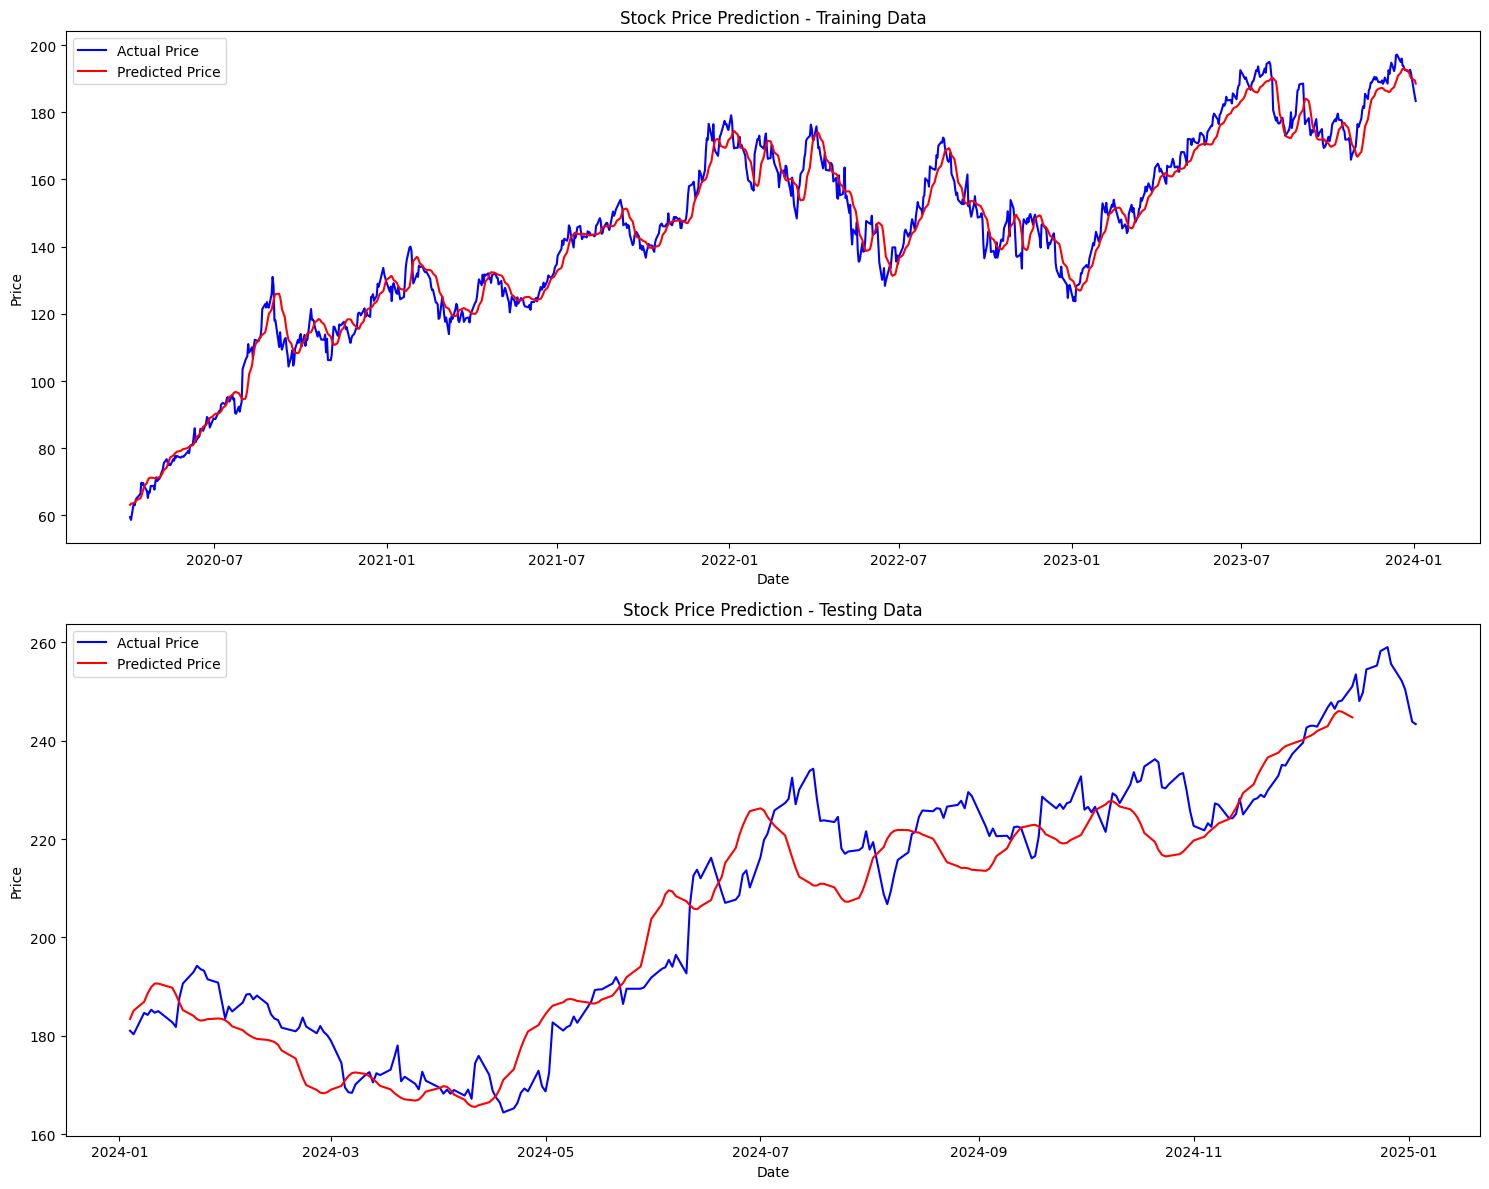

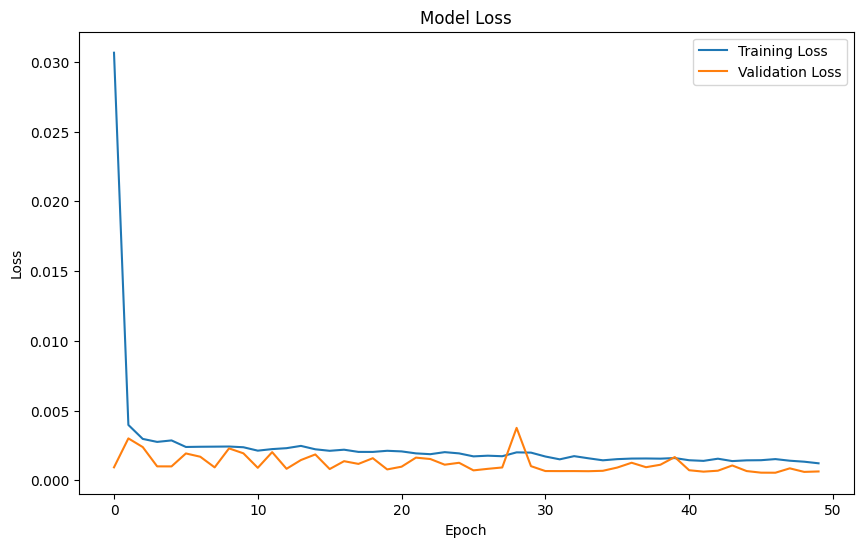


Model Performance Metrics (Test Set):
Root Mean Squared Error: $7.95
Mean Absolute Error: $6.43
R-squared Score: 0.9058


In [ ]:
import os
import tensorflow as tf
from datetime import datetime, timedelta

if __name__ == "__main__":
    
    TICKER = "AAPL"  # stock ticker for Apple Inc. Company
    LOOK_BACK = 60    # no. of previous days to use for prediction
    SPLIT_RATIO = 0.8
    EPOCHS = 50
    BATCH_SIZE = 32
    MODEL_PATH = "lstm_model.h5"  
    
    # data for the last 5 years
    end_date = datetime.now()
    start_date = end_date - timedelta(days=5 * 365)
    
    print(f"Fetching {TICKER} stock data...")
    df = get_stock_data(TICKER, start_date, end_date)

    print("Dataset preview:")
    print(df.head())
    
    # data preprocessing
    print("Preparing data...")
    X_train, X_test, y_train, y_test, scaler = prepare_data(df, LOOK_BACK, SPLIT_RATIO)
    
    # train or load model
    if os.path.exists(MODEL_PATH):
        print(f"Loading model from {MODEL_PATH}...")
        model = tf.keras.models.load_model(MODEL_PATH)
    else:
        print("Creating and training a new LSTM model...")
        model = create_lstm_model(LOOK_BACK)
        
        history = train_and_evaluate(model, X_train, X_test, y_train, y_test, scaler, EPOCHS, BATCH_SIZE)
    
    # predict stock prices
    print("Making predictions...")
    train_predict, test_predict, y_train_inv, y_test_inv = load_and_predict(
        MODEL_PATH, X_train, X_test, y_train, y_test, scaler
    )
    
    # visualization 
    print("Plotting results...")
    plot_results(df, train_predict, test_predict, LOOK_BACK, SPLIT_RATIO)
    plot_loss(history)  
    
    # calc performance metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    mse = mean_squared_error(y_test_inv.flatten(), test_predict.flatten())
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv.flatten(), test_predict.flatten())
    r2 = r2_score(y_test_inv.flatten(), test_predict.flatten())
    
    print("\nModel Performance Metrics (Test Set):")
    print(f"Root Mean Squared Error: ${rmse:.2f}")
    print(f"Mean Absolute Error: ${mae:.2f}")
    print(f"R-squared Score: {r2:.4f}")


**First Plot and Second Plots**: The two plots suggest that the model predicts well accurately on the training data while accuracy is a little less at 90.58% for test data which is still good.

**Third Plot**: The plot shows that the model effectively minimizes loss over epochs, indicating good performance in predicting stock prices, with stable validation loss suggesting no overfitting.

#### Future Improvements:

- This project can be extended to creating a dashboard that predicts stock prices in real time allowing investors to make data-driven informed decisions
- Sentiment analysis can also be added as a feature to predict stock prices, adapting to real-world scenario
- Multiple companies stock data can also be accumulated instead of one individual stock giving way to personalized investment portfolio for the user.

---